In [1]:
# Mount Google Drive (specific to Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import time

def start_timer():
    global start_time
    start_time = time.time()
    print(f"Timer started at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(start_time))}")

def stop_timer():
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Timer stopped at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(end_time))}")
    print(f"Elapsed time: {elapsed_time} seconds")


# **Import The Needed Library**

In [3]:
start_timer()

# Standard library imports
import os
import json
import random
import warnings
import itertools


# Data manipulation and scientific computing
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and neural network libraries
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (BatchNormalization, Bidirectional, Conv1D,
                                     Dense, Dropout, LSTM, MaxPooling1D, Activation,
                                     AveragePooling1D, Concatenate, LayerNormalization,
                                     Add, Lambda, Flatten, Layer)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model evaluation metrics
from sklearn.metrics import (confusion_matrix, f1_score, recall_score,
                             precision_score, accuracy_score, classification_report)
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

# Filter out all warnings
warnings.filterwarnings("ignore")

# Disable TensorFlow warnings
tf.get_logger().setLevel('ERROR')


Timer started at 2024-06-03 19:49:12


# **Load the WISDM Dataset**

In [4]:
file_path ='/content/drive/MyDrive/WISDM/WISDM_ar_v1.1_cleaned.txt'
model_save_path = '/content/drive/MyDrive/WISDM/WISDM-CNN.hdf5'


colnames = ['users', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
dataset = pd.read_csv(file_path, names=colnames)
dataset = dataset.dropna()

# Further data cleaning of the database: convert the 'x-axis', 'y-axis', 'z-axis' to numeric values by removing and ; or ,
for axis in ['x-axis', 'y-axis', 'z-axis']:
    dataset[axis] = dataset[axis].astype(str).str.replace(';', '').astype(np.float32)

n_time_step = 128
step = 64
n_feature = 3
segments = []
labels = []

for i in range(0, len(dataset) - n_time_step, step):
    x = dataset['x-axis'].values[i: i + n_time_step]
    y = dataset['y-axis'].values[i: i + n_time_step]
    z = dataset['z-axis'].values[i: i + n_time_step]
    segment_labels = dataset['activity'][i: i + n_time_step]
    # Use pandas to find the most frequent label
    label = segment_labels.value_counts().idxmax()
    segments.append([x, y, z])
    labels.append(label)

reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, n_time_step, n_feature)
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=1)

# **Define the Attention Model**

In [5]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'step_dim': self.step_dim,
            'W_regularizer': self.W_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
        })
        return config

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

# **Define the Model Structure**

In [6]:
class CNNAttentionModel:

    def __init__(self, kernel_size, learning_rate, batch_size):
        self.model = None
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def CNN_Attention(self, input_forward, input_backward, kernel_size):
        # 1D-CNN layers with different kernels
        conv1_forward = Conv1D(128, kernel_size, activation='relu', padding='same')(input_forward)
        conv1_backward = Conv1D(128, kernel_size, activation='relu', padding='same')(input_backward)

        # Concatenate CNN outputs
        concatenated = Concatenate()([conv1_forward, conv1_backward])

        # Batch Normalization
        model = BatchNormalization()(concatenated)

        # Max Pooling
        model = MaxPooling1D(pool_size=2)(model)

        # Dropout
        model = Dropout(0.2)(model)

        # Additional Conv1D layers
        model = Conv1D(128, kernel_size, activation='relu', padding='same')(model)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        model = Conv1D(128//2, kernel_size, activation='relu', padding='same')(model)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        model = Conv1D(128//4, kernel_size, activation='relu', padding='same')(model)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        # Layer Normalization
        model = LayerNormalization()(model)

        # Extra CNN layer for demonstration
        model = Conv1D(128//8, kernel_size, activation='relu', padding='same')(model)

        # Attention layer
        output = Attention(8)(model)

        return output

    def create_model(self, kernel_size, learning_rate, batch_size):
        # Define the input layers
        input_1_forward = Input(shape=(128, 3))
        input_1_backward = Input(shape=(128, 3))

        # Flip the second input data
        input_1_backward_flipped = Lambda(lambda x: K.reverse(x, axes=1))(input_1_backward)

        model1 = self.CNN_Attention(input_1_forward, input_1_backward_flipped, kernel_size)

        output = Dropout(0.2)(model1)
        output = Dense(6)(output)
        output = Activation('softmax', name="softmax")(output)
        self.model = Model(inputs=[input_1_forward, input_1_backward_flipped], outputs=output)
        self.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),metrics=['accuracy'] )


    def fit(self, X, y, kernel_size, learning_rate, batch_size, epochs, validation_data):
        self.create_model(kernel_size, learning_rate, batch_size)

        # Callbacks
        callbacks = []
        callbacks.append(EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True))
        callbacks.append(ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1))

        # Training the model with validation
        history = self.model.fit(
             X, y,
             batch_size=batch_size,
             epochs=epochs,
             verbose=1,
             validation_data=validation_data,
             callbacks=callbacks
         )
        return history




    def score(self, X, y):
        loss, accuracy = self.model.evaluate(X, y, verbose=0)
        return accuracy


    def get_params(self, deep=True):
        return {
            'kernel_size': self.kernel_size,
            'learning_rate': self.learning_rate,
            'batch_size': self.batch_size
        }


    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# **Train and Test The Model**

Epoch 1/150
344/344 [==============================] - ETA: 0s - loss: 1.1121 - accuracy: 0.5967
Epoch 1: val_accuracy improved from -inf to 0.77021, saving model to /content/drive/MyDrive/WISDM/WISDM-CNN.hdf5
344/344 [==============================] - 21s 22ms/step - loss: 1.1121 - accuracy: 0.5967 - val_loss: 0.6173 - val_accuracy: 0.7702
Epoch 2/150
342/344 [============================>.] - ETA: 0s - loss: 0.7214 - accuracy: 0.7463
Epoch 2: val_accuracy improved from 0.77021 to 0.84523, saving model to /content/drive/MyDrive/WISDM/WISDM-CNN.hdf5
344/344 [==============================] - 5s 13ms/step - loss: 0.7221 - accuracy: 0.7462 - val_loss: 0.4299 - val_accuracy: 0.8452
Epoch 3/150
342/344 [============================>.] - ETA: 0s - loss: 0.5732 - accuracy: 0.7980
Epoch 3: val_accuracy improved from 0.84523 to 0.87800, saving model to /content/drive/MyDrive/WISDM/WISDM-CNN.hdf5
344/344 [==============================] - 5s 15ms/step - loss: 0.5733 - accuracy: 0.7980 - val_los

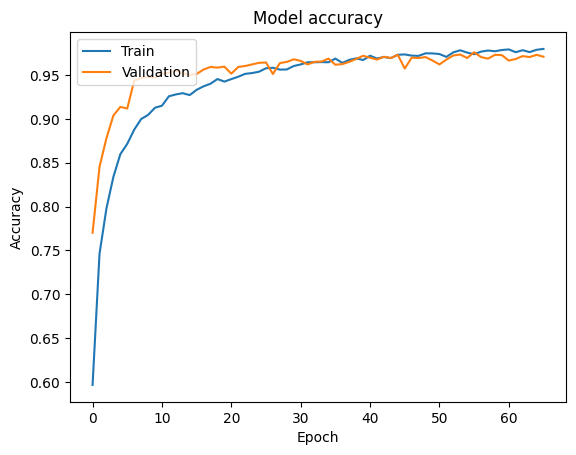

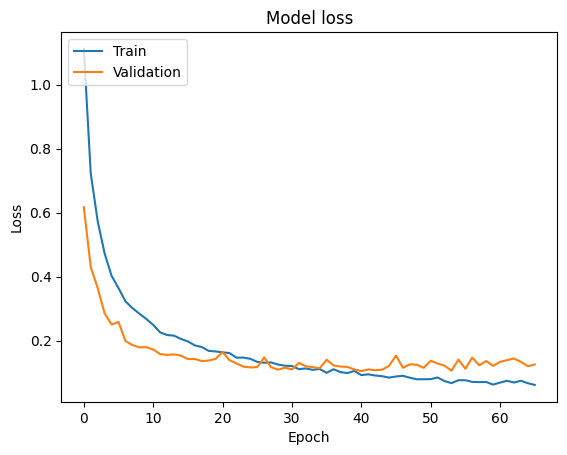

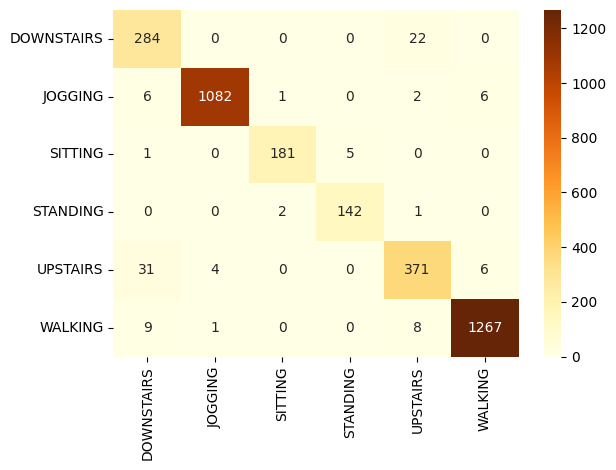

Metrics for DOWNSTAIRS:
  True Positives (TP): 284
  True Negatives (TN): 3079
  False Positives (FP): 47
  False Negatives (FN): 22

Metrics for JOGGING:
  True Positives (TP): 1082
  True Negatives (TN): 2330
  False Positives (FP): 5
  False Negatives (FN): 15

Metrics for SITTING:
  True Positives (TP): 181
  True Negatives (TN): 3242
  False Positives (FP): 3
  False Negatives (FN): 6

Metrics for STANDING:
  True Positives (TP): 142
  True Negatives (TN): 3282
  False Positives (FP): 5
  False Negatives (FN): 3

Metrics for UPSTAIRS:
  True Positives (TP): 371
  True Negatives (TN): 2987
  False Positives (FP): 33
  False Negatives (FN): 41

Metrics for WALKING:
  True Positives (TP): 1267
  True Negatives (TN): 2135
  False Positives (FP): 12
  False Negatives (FN): 18

Timer stopped at 2024-06-03 19:56:06
Elapsed time: 413.9484632015228 seconds


In [7]:
best_params = {
    'learning_rate': 0.0001,
    'kernel_size': 5,
    'batch_size': 32
}


# Reserve a portion of the training data for validation
x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42
)


# Train the final model using the best hyperparameters
best_model = CNNAttentionModel(kernel_size=best_params['kernel_size'],
                               learning_rate=best_params['learning_rate'],
                               batch_size=best_params['batch_size'])


# Fit the model to the training data with validation data
history = best_model.fit(
    X=[
        x_train_final,
        np.flip(x_train_final, axis=1)
    ],
    y=y_train_final,
    kernel_size=best_params['kernel_size'],
    learning_rate=best_params['learning_rate'],
    batch_size=best_params['batch_size'],
    epochs=150,
    validation_data=(
        [
            x_val_final,
            np.flip(x_val_final, axis=1)
        ],
        y_val_final
    )
)

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.model.evaluate([X_test, np.flip(X_test, axis=1)],
                                                     y_test, verbose=0)

# Calculate additional evaluation metrics
y_pred = best_model.model.predict([X_test, np.flip(X_test, axis=1)])

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate various precision, recall, and F1 scores
precision_macro = precision_score(y_true_labels, y_pred_labels, average='macro')
precision_weighted = precision_score(y_true_labels, y_pred_labels, average='weighted')
precision_micro = precision_score(y_true_labels, y_pred_labels, average='micro')

recall_macro = recall_score(y_true_labels, y_pred_labels, average='macro')
recall_weighted = recall_score(y_true_labels, y_pred_labels, average='weighted')
recall_micro = recall_score(y_true_labels, y_pred_labels, average='micro')

f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
f1_weighted = f1_score(y_true_labels, y_pred_labels, average='weighted')
f1_micro = f1_score(y_true_labels, y_pred_labels, average='micro')

accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Calculate per-class accuracy
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Calculate macro accuracy
macro_accuracy = per_class_accuracy.mean()

# Calculate weighted accuracy
weighted_accuracy = np.average(per_class_accuracy, weights=np.bincount(y_true_labels))

population_std_dev_true = np.std(y_true_labels, ddof=0)
population_std_dev_pred = np.std(y_pred_labels, ddof=0)

sample_std_dev_true = np.std(y_true_labels, ddof=1)
sample_std_dev_pred = np.std(y_pred_labels, ddof=1)


# Print model summary
best_model.model.summary()

# Print evaluation metrics
average_accuracy = np.mean(history.history['accuracy'])
best_accuracy = np.max(history.history['accuracy'])
last_accuracy = history.history['accuracy'][-1]

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Average Accuracy: {average_accuracy}")
print(f"Best Accuracy: {best_accuracy}")
print(f"Last Epoch Accuracy: {last_accuracy}")

print(f"Micro Accuracy: {accuracy:.4f}")
print(f"Macro Accuracy: {macro_accuracy:.4f}")
print(f"Weighted Accuracy: {weighted_accuracy:.4f}")

print("Precision (Macro):", precision_macro)
print("Precision (Weighted):", precision_weighted)
print("Precision (Micro):", precision_micro)

print("Recall (Macro):", recall_macro)
print("Recall (Weighted):", recall_weighted)
print("Recall (Micro):", recall_micro)

print("F1 Score (Macro):", f1_macro)
print("F1 Score (Weighted):", f1_weighted)
print("F1 Score (Micro):", f1_micro)

print("Population Std Dev - True Labels:", population_std_dev_true)
print("Population Std Dev - Predicted Labels:", population_std_dev_pred)
print("Sample Std Dev - True Labels:", sample_std_dev_true)
print("Sample Std Dev - Predicted Labels:", sample_std_dev_pred)
print("_______________________________________________________________\n")


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate y_true and y_pred_classes
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
cm = pd.DataFrame(conf_matrix, columns=['DOWNSTAIRS', 'JOGGING', 'SITTING', 'STANDING', 'UPSTAIRS', 'WALKING'],
                  index=['DOWNSTAIRS', 'JOGGING', 'SITTING', 'STANDING', 'UPSTAIRS', 'WALKING'])
sns.heatmap(cm, cmap="YlOrBr", fmt="d", annot=True)
plt.tight_layout()
plt.show()

# Calculate TP, TN, FP, FN for each class
def calculate_confusion_metrics(conf_matrix):
    TP = np.diag(conf_matrix)  # True Positives are on the diagonal
    FP = np.sum(conf_matrix, axis=0) - TP  # False Positives are column sums minus TP
    FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives are row sums minus TP
    TN = conf_matrix.sum() - (FP + FN + TP)  # True Negatives are total sum minus FP, FN, TP

    return TP, TN, FP, FN

TP, TN, FP, FN = calculate_confusion_metrics(conf_matrix)

# Print results for each class
classes = ['DOWNSTAIRS', 'JOGGING', 'SITTING', 'STANDING', 'UPSTAIRS', 'WALKING']
for i, class_label in enumerate(classes):
    print(f"Metrics for {class_label}:")
    print(f"  True Positives (TP): {TP[i]}")
    print(f"  True Negatives (TN): {TN[i]}")
    print(f"  False Positives (FP): {FP[i]}")
    print(f"  False Negatives (FN): {FN[i]}\n")

stop_timer()